In [ ]:
# Install notebook dependencies
import sys
!{sys.executable} -m pip install itk itk-ultrasound numpy matplotlib requests

In [13]:
import os
import sys
import shutil

import numpy as np
import requests
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive
from IPython.display import display

import itk

In [24]:
# Download data
input_filename = 'EyeRoundOverChuck_5.0MHz_20V.mha'
if not os.path.exists(input_filename):
    response = requests.get('https://data.kitware.com/api/v1/file/57b5d9268d777f10f2694f9d/download', stream=True)
    with open(input_filename, 'wb') as fp:
        response.raw.decode_content = True
        shutil.copyfileobj(response.raw, fp)

In [29]:
import itkConfig
Dimension = 2
IntegerPixelType = itk.SS
IntegerImageType = itk.CurvilinearArraySpecialCoordinatesImage[IntegerPixelType, Dimension]
RealPixelType = itk.F
RealImageType = itk.CurvilinearArraySpecialCoordinatesImage[RealPixelType, Dimension]
ComplexPixelType = itk.complex[RealPixelType]
ComplexImageType = itk.CurvilinearArraySpecialCoordinatesImage[ComplexPixelType, Dimension]
ScanConvertedImageType = itk.Image[RealPixelType, Dimension]

In [30]:
ReaderType = itk.ImageFileReader[IntegerImageType]
reader = ReaderType.New()
reader.SetFileName(input_filename)
reader.Update()

In [31]:
aline_samples = reader.GetOutput().GetLargestPossibleRegion().GetSize()[0]
print(aline_samples)

2048


In [32]:
curvilinear_array_image = reader.GetOutput()
curvilinear_array_image.DisconnectPipeline()
input_size = curvilinear_array_image.GetLargestPossibleRegion().GetSize()
lateral_angular_separation = (np.pi  / 2.0 + 0.5) / (input_size[1] - 1)
curvilinear_array_image.SetLateralAngularSeparation(lateral_angular_separation)
radius_start = 26.4
radius_stop = 131.5
curvilinear_array_image.SetFirstSampleDistance(radius_start)
curvilinear_array_image.SetRadiusSampleSize( (radius_stop - radius_start) / (input_size[0] - 1) )

In [33]:
TGCType = itk.TimeGainCompensationImageFilter[IntegerImageType]
tgc_filter= TGCType.New()
tgc_filter.SetInput(curvilinear_array_image)

In [34]:
num_gain_controls = 5
gain = itk.Array2D[itk.D](num_gain_controls, 2)
for ii in np.arange(num_gain_controls):
    gain.SetElement(ii, 0, float(ii) / (num_gain_controls - 1) * aline_samples)
    gain.SetElement(ii, 1, 1.0)
tgc_filter.SetGain(gain)
print(str(tgc_filter))

TimeGainCompensationImageFilter (0xc623750)
  RTTI typeinfo:   itk::TimeGainCompensationImageFilter<itk::CurvilinearArraySpecialCoordinatesImage<short, 2u>, itk::CurvilinearArraySpecialCoordinatesImage<short, 2u> >
  Reference Count: 1
  Modified Time: 1181
  Debug: Off
  Object Name: 
  Observers: 
    none
  Inputs: 
    Primary: (0x7cf2210) *
  Indexed Inputs: 
    0: Primary (0x7cf2210)
  Required Input Names: Primary
  NumberOfRequiredInputs: 1
  Outputs: 
    Primary: (0xdccecb0)
  Indexed Outputs: 
    0: Primary (0xdccecb0)
  NumberOfRequiredOutputs: 1
  Number Of Threads: 8
  ReleaseDataFlag: Off
  ReleaseDataBeforeUpdateFlag: Off
  AbortGenerateData: Off
  Progress: 0
  Multithreader: 
    RTTI typeinfo:   itk::MultiThreader
    Reference Count: 1
    Modified Time: 1168
    Debug: Off
    Object Name: 
    Observers: 
      none
    Thread Count: 8
    Global Maximum Number Of Threads: 128
    Global Default Number Of Threads: 8
  CoordinateTolerance: 1e-06
  DirectionTolera

In [35]:
CasterType = itk.CastImageFilter[IntegerImageType, RealImageType]
caster = CasterType.New()
caster.SetInput(tgc_filter.GetOutput())

In [36]:
BModeFilterType = itk.BModeImageFilter[RealImageType, RealImageType,
                                       ComplexImageType]
bmode_filter = BModeFilterType.New()
bmode_filter.SetInput(caster.GetOutput())
bmode_filter.Update()

In [39]:
ResamplerType = itk.ResampleImageFilter[RealImageType, ScanConvertedImageType]
resampler = ResamplerType.New()
resampler.SetInput(bmode_filter.GetOutput())
output_size = (800, 800)
resampler.SetSize(output_size)
output_spacing = (0.15, 0.15)
resampler.SetOutputSpacing(output_spacing)
output_origin = [0, 0]
output_origin[0] = output_size[0] * output_spacing[0] / -2.0
output_origin[1] = radius_start * np.cos(np.pi / 4.0)
resampler.SetOutputOrigin(output_origin)
resampler.Update()

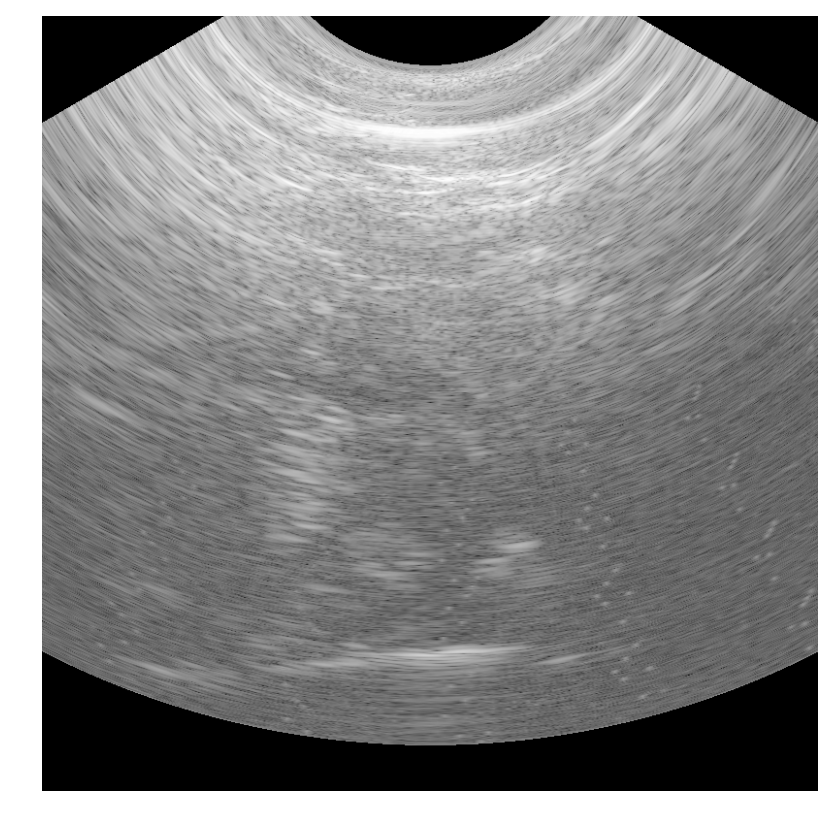

In [40]:
bmode = resampler.GetOutput()
bmode_array = itk.PyBuffer[ScanConvertedImageType].GetArrayFromImage(bmode)

fig = plt.figure(1, figsize=(10, 10))

ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(bmode_array, cmap='gray');

(0, 2048L)

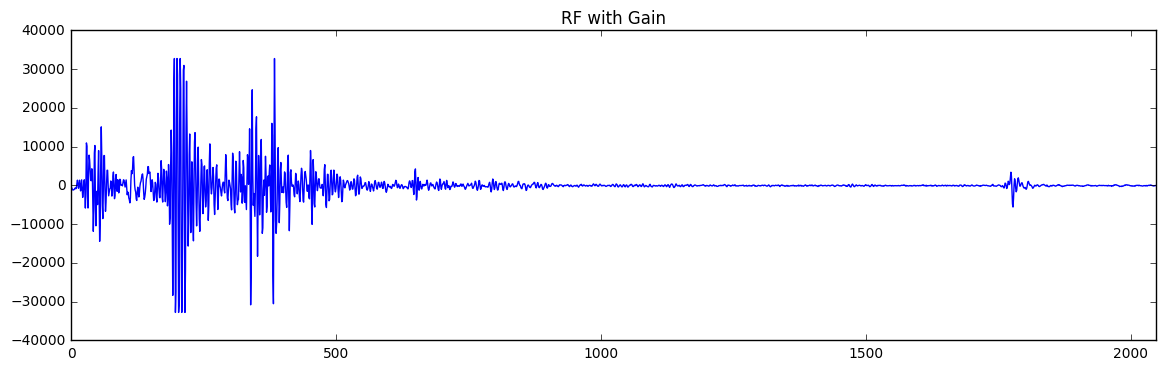

In [41]:
CastRFImageType = itk.Image[IntegerPixelType, Dimension]
ImageCasterType = itk.CastImageFilter[IntegerImageType, CastRFImageType]
image_caster = ImageCasterType.New()
image_caster.SetInput(tgc_filter.GetOutput())
image_caster.Update()

rf_with_gain = itk.PyBuffer[CastRFImageType].GetArrayFromImage(image_caster.GetOutput())

fig = plt.figure(2, figsize=(14, 4))
ax = fig.add_subplot(1,1,1)
ax.plot(rf_with_gain[120, :])
ax.set_title('RF with Gain')
ax.set_xlim(0, aline_samples)

In [43]:
def show_tgc(gain1=1.0, gain2=1.0, gain3=3.0, gain4=5.0, gain5=7.0):
    """Adjusts the gain based on the passed values and displays the result."""
    gain.SetElement(0, 1, gain1)
    gain.SetElement(1, 1, gain2)
    gain.SetElement(2, 1, gain3)
    gain.SetElement(3, 1, gain4)
    gain.SetElement(4, 1, gain5)
    tgc_filter.SetGain(gain)
    
    resampler.Update()
    bmode = resampler.GetOutput()
    bmode_array = itk.PyBuffer[ScanConvertedImageType].GetArrayFromImage(bmode)
           
    image_caster.Update()
    rf_with_gain = itk.PyBuffer[CastRFImageType].GetArrayFromImage(image_caster.GetOutput())

    fig = plt.figure(3, figsize=(16, 8))

    ax = fig.add_subplot(1,2,1)
    ax.plot(rf_with_gain[120, :], np.arange(len(rf_with_gain[120, :]), 0, -1))
    ax.set_title('RF with Gain')
    ax.set_ylim(-200, aline_samples+200)

    ax = fig.add_subplot(1,2,2)
    ax.axis('off')
    ax.imshow(bmode_array, cmap='gray')
    
max_gain = 10.1
gain_step = 0.1
widget = interactive(show_tgc,
             gain1=(0.0, max_gain, gain_step),
             gain2=(0.0, max_gain, gain_step),
             gain3=(0.0, max_gain, gain_step),
             gain4=(0.0, max_gain, gain_step),
             gain5=(0.0, max_gain, gain_step))
display(widget)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTEuMCwgZGVzY3JpcHRpb249dSdnYWluMScsIG1heD0xMC4xKSwgRmxvYXRTbGlkZXIodmFsdWU9MS4wLCBkZXNjcmlwdGnigKY=


## Plotting the Gain Curve

In [44]:
rf_with_gain.shape

(241, 2048)

In [45]:
ones_array = np.ones(rf_with_gain.shape, dtype=np.float32)
ones_image = itk.PyBuffer[ScanConvertedImageType].GetImageFromArray(ones_array)

In [46]:
OnesTGCType = itk.TimeGainCompensationImageFilter[ScanConvertedImageType]
ones_tgc_filter = OnesTGCType.New()
ones_tgc_filter.SetInput(ones_image)
ones_tgc_filter.SetGain(gain)
ones_tgc_filter.Update()

In [47]:
gain_array = itk.GetArrayViewFromImage(ones_tgc_filter)

(0, 2048L)

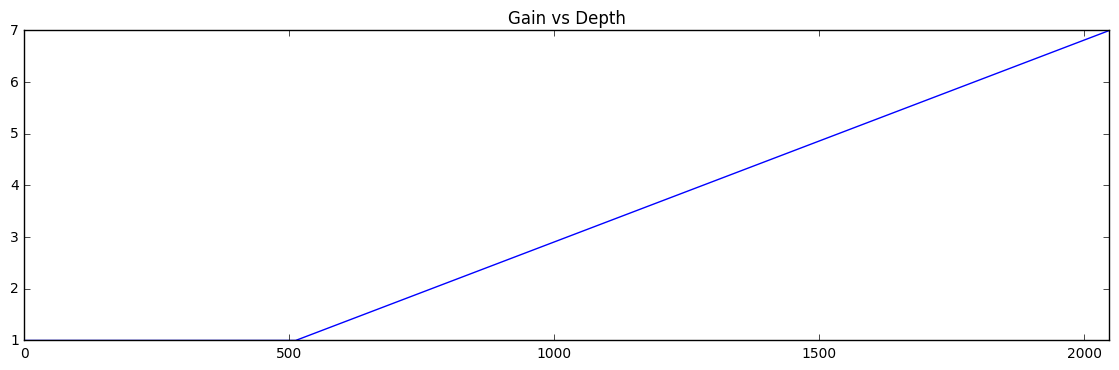

In [48]:
fig = plt.figure(3, figsize=(14, 4))
ax = fig.add_subplot(1,1,1)
ax.plot(gain_array[120, :])
ax.set_title('Gain vs Depth')
ax.set_xlim(0, aline_samples)